In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
import glob
from tqdm.notebook import tqdm

# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

import config, utils
from dataset import BodyPartDataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preprocessing

In [2]:
with open(config.TRAIN_IDS) as f:
    train_ids = f.read().splitlines()
    
with open(config.VAL_IDS) as f:
    val_ids = f.read().splitlines()

val_ids, test_ids = train_test_split(val_ids, test_size=config.TEST_SIZE, random_state=42)

In [3]:
images = glob.glob(config.IMAGE_DIR + '/**/*.jpg', recursive=True)
masks = glob.glob(config.MASK_DIR + '/**/*.npy', recursive=True)

In [4]:
# out_dir = '/home/gpuuser/hs/Pascal-part/test'
# for i, im_id in enumerate(test_ids[0:]):    
#     image = cv2.imread(os.path.join(image_dir, im_id + '.jpg'))
#     mask = np.uint8(np.load(os.path.join(mask_dir, im_id + '.png')))
#     cv2.imwrite(os.path.join(out_dir, tr_id + '.jpg'), image)
#     cv2.imwrite(os.path.join(out_dir, tr_id + '.png'), mask)

Image Size (442, 500, 3)
Mask Size (442, 500)


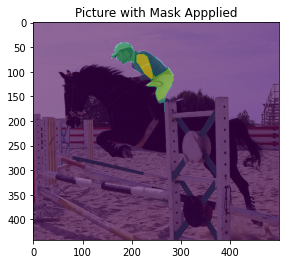

In [4]:
i = 1
img = Image.open(os.path.join(config.IMAGE_DIR, train_ids[i] + '.jpg'))
mask = Image.fromarray(np.uint8(np.load(os.path.join(config.MASK_DIR, train_ids[i] + '.npy'))))

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [5]:
train_samples = glob.glob('./Pascal-part/train' + '/**/*.jpg', recursive=True)
val_samples = glob.glob('./Pascal-part/val' + '/**/*.jpg', recursive=True)
test_samples = glob.glob('./Pascal-part/test' + '/**/*.jpg', recursive=True)

In [6]:
train_transforms = A.Compose([
                                A.Resize(config.IMG_SIZE, config.IMG_SIZE, interpolation=cv2.INTER_NEAREST),
                                A.HorizontalFlip(),
                                A.VerticalFlip(),
                                A.GridDistortion(p=0.2),
                                A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                                A.GaussNoise(),
    
#                                 A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
#                                 A.OneOf([
#                                         A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
#                                         A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
#                                         A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
#                                     ], p=0.25),
#                                 A.CoarseDropout(max_holes=8, max_height=config.IMG_SIZE//20, max_width=config.IMG_SIZE//20,
#                                                  min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
    
#                                 A.Blur(),
#                                 A.ChannelDropout(),
#                                 A.ElasticTransform(p=0.2),
#                                 A.ISONoise(),

#                                 A.RandomCrop(width=448, height=288, p=1.0),
#                                 A.Rotate(limit=[60, 240], p=1.0, interpolation=cv2.INTER_NEAREST),
#                                 A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.4], contrast_limit=0.2, p=1.0),
#                                 A.OneOf([
#                                     A.CLAHE (clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
#                                     A.GridDistortion(p=0.5),
#                                     A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
#                                 ], p=1.0),
    
                            ])

val_transforms = A.Compose([
                            A.Resize(config.IMG_SIZE, config.IMG_SIZE, interpolation=cv2.INTER_NEAREST),
                            A.HorizontalFlip(),
                            A.GridDistortion(p=0.2)
                            ])

train_set = BodyPartDataset('./Pascal-part/train', config.MEAN, config.STD, False, train_transforms)
val_set = BodyPartDataset('./Pascal-part/val', config.MEAN, config.STD, False, val_transforms)

train_loader = DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=config.BATCH_SIZE, shuffle=True)               

## Model

In [8]:
# model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=7, activation=None, encoder_depth=5,
#                  decoder_channels=[256, 128, 64, 32, 16])
# model = smp.Unet('vgg19', encoder_weights='imagenet', classes=7, activation=None, encoder_depth=5,
#                  decoder_channels=[256, 128, 64, 32, 16])
model = smp.DeepLabV3('mobilenet_v2', encoder_weights='imagenet', classes=7, activation=None, encoder_depth=5,
                 decoder_channels=256)
# model = smp.FPN("mobilenet_v2", classes=7)
# model = smp.Unet('timm-efficientnet-b3', encoder_weights=None, classes=7)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.MAX_LR, weight_decay=config.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, config.MAX_LR, epochs=config.EPOCHS, steps_per_epoch=len(train_loader))

## Train

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
exp_name = 'timm-efficientnet-b3-512'
history = utils.fit(config.EPOCHS, model, device, train_loader, val_loader, criterion, optimizer, scheduler, exp_name)

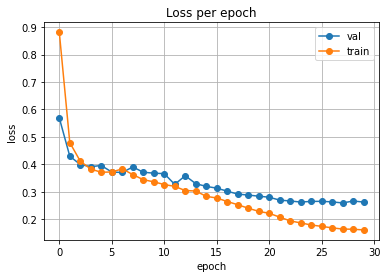

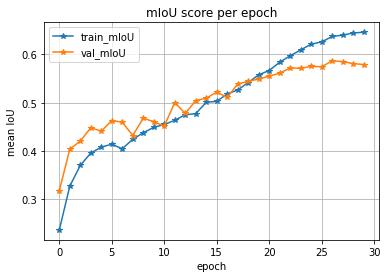

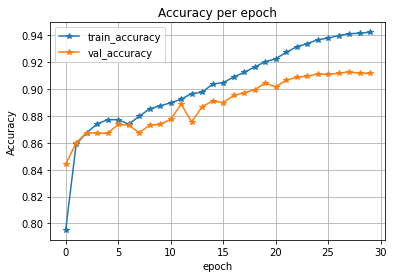

In [12]:
# utils.plot_loss(history)
# utils.plot_score(history)
# utils.plot_acc(history)

## Evaluation

In [43]:
test_transforms = A.Resize(config.IMG_SIZE, config.IMG_SIZE, interpolation=cv2.INTER_NEAREST)
test_set = BodyPartDataset('./Pascal-part/test', config.MEAN, config.STD, True, test_transforms)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('./models/DeepLabV3-512_29_epoch_mIoU-0.579.pt', map_location=device)
model.eval();

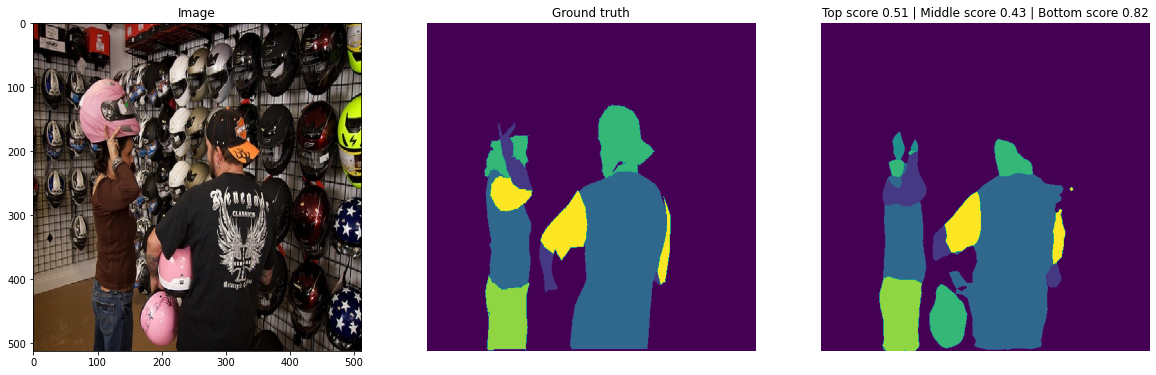

In [56]:
image, mask = test_set[23]

pred_mask, score, top_score, mid_score, bot_score = utils.predict_image_mask_miou(model, device, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
# ax3.imshow(image)
# ax3.imshow(pred_mask, alpha=0.5)
ax3.set_title('Top score {:.2f} | Middle score {:.2f} | Bottom score {:.2f}'.format(top_score, mid_score, bot_score))
ax3.set_axis_off()

In [57]:
miou, top_miou, middle_miou, bottom_miou = utils.miou_score(model, device, test_set)
print(f'General mIoU: {miou:.3f}, Top mIoU: {top_miou:.3f}, Middle mIoU: {middle_miou:.3f}, Bottom mIoU: {bottom_miou:.3f}')

  0%|          | 0/307 [00:00<?, ?it/s]

General mIoU: 0.492, Top mIoU: 0.393, Middle mIoU: 0.422, Bottom mIoU: 0.286


In [58]:
accuracy = utils.accuracy_score(model, device, test_set)
print(f'Pixel Accuracy: {accuracy:.3f}')

  0%|          | 0/307 [00:00<?, ?it/s]

Pixel Accuracy: 0.933
